In [23]:
%pylab inline
import scipy.stats as sps
import scipy.integrate as spi
import seaborn as sns
import csv

import dask
from dask.distributed import Client

import time

from dask_jobqueue import SLURMCluster

sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


In [24]:
run_local = False
n_workers_init = 6

if run_local:
    client = Client()
    client.cluster.scale(n_workers_init)
    time.sleep(0.5) # allow client time to respond to scaling before display
else:
    # note the specifed walltime, don't use too much or too little, 01:30:00 is a good baseline, 
    # you just need enough time to finish 'gathering' to props_all before the jobs die
    # you can always spin up more jobs later
    # you will launch many jobs, so you don't need multiple processes, a lot of ram or multiple threads
#     cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',threads=1,processes=1,memory='6GB')
    
    #SHORT RUNS
#     cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',cores=1,processes=1,memory='6G')
    cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',cores=1,processes=1,memory='6G')
    cluster.start_workers(n_workers_init)
    client = Client(cluster)

client

FileNotFoundError: [Errno 2] No such file or directory: 'sbatch': 'sbatch'

In [16]:
def save_experiment(exp_key, res, kwargs, kwargs_s):

    # Save NN
    np.save('./eexp_'+exp_key, res)
    # Save metadata (parameters)
    file = open('./eexp_'+exp_key+'_meta.csv', "w")
    w = csv.writer(file)
    for key, val in kwargs.items():
        w.writerow([key, val])
    for key, val in kwargs_s.items():
        w.writerow([key, val])
    file.close()

def integrand_1(s, Ts):
    return np.exp(-s)*Ts.pdf(s)

def integral_1(ta, t, Ts):
    return spi.quad(integrand_1, ta, t, args=(Ts))[0]

def mN_det_Ta(mTa, t, Ts):
    # OJO: Only when t > ta
    return np.exp(t)*integral_1(mTa, t, Ts) + 1 - Ts.cdf(t)

def integrand_2(ta, t, Ta, Ts):
    return Ta.pdf(ta)*integral_1(ta, t, Ts)

def integral_2(t, Ta, Ts):
    return spi.quad(integrand_2, 0, t, args=(t, Ta, Ts))[0]

def mN_stoch_Ta(t, Ta, Ts):
    return np.exp(t)*integral_2(t, Ta, Ts)+1-Ts.cdf(t)

def run_deterministic_one(mTs, sTs, mTa, sTa=0, tg=8):
    Ts = sps.norm(mTs, sTs)
    return mN_det_Ta(mTa, tg, Ts)

def run_deterministic_single_sTs(sTs, MTs, mTa, sTa, tg=8):
    N = np.zeros(len(MTs))
    for i in range(len(MTs)):
        mTs = MTs[i]
        N[i] = run_deterministic_one(mTs, sTs, mTa, sTa=0, tg=8)
    return N

def run_deterministic(MTs, STs, mTa, sTa=0, tg=8):
    
    NN = np.zeros((len(MTs), len(STs)))
    
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            
            NN[i,j] = run_deterministic_one(mTs, sTs, mTa, sTa=0, tg=tg)
#             Ts = sps.norm(mTs, sTs)
#             NN[i,j] = mN_det_Ta(mTa, tg, Ts)
    return NN

def run_stochastic_one(mTs, sTs, mTa, sTa, tg):
    Ts = sps.expon(scale = mTs)
    Ta = sps.norm(mTa, sTa)
    return mN_stoch_Ta(tg, Ta, Ts)

def run_stochastic_single_sTs(sTs, MTs, mTa, sTa, tg):
    N = np.zeros(len(MTs))
    for i in range(len(MTs)):
        mTs = MTs[i]
        print(mTs)
        N[i] = run_stochastic_one(mTs, sTs, mTa, sTa, tg=8)
    return N

def run_stochastic(MTs, STs, Ta, tg):
    
    NN = np.zeros((len(MTs), len(STs)))
    
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            Ts = sps.norm(mTs, sTs)
            NN[i,j] = mN_stoch_Ta(tg, Ta, Ts)
    return NN



In [17]:
mTa = 3
sTa = 0.5 # deterministic Ta
tg = 8

MTs_start = 0.05
MTs_stop = 8
MTs_step = 0.05

STs_start = 0.05
STs_stop = 2
STs_step = 0.05

kwargs_s = {'MTs_start':MTs_start, 'MTs_stop':MTs_stop, 'MTs_step':MTs_step,
            'STs_start':STs_start, 'STs_stop':STs_stop, 'STs_step':STs_step}

MTs = np.arange(MTs_start, MTs_stop, MTs_step)
STs = np.arange(STs_start, STs_stop, STs_step)

kwargs = {'mTa':mTa, 'sTa':sTa, 'tg':tg}

exp_key = '804'

# NN = run_deterministic(MTs, STs, mTa, sTa=0, tg=8)
# Ta = sps.norm(mTa, sTa)
# NN = run_stochastic(MTs, STs, Ta, tg=8)
# save_experiment(exp_key, NN, kwargs, kwargs_s)

In [18]:
sTs = 0
N = run_stochastic_single_sTs(sTs, MTs, mTa, sTa, tg)

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.8500000000000005
4.9
4.95
5.0
5.05
5.1000000000000005
5.15
5.2
5.25
5.3
5.3500000000000005
5.4
5.45
5.5
5.55
5.6000000000000005
5.65
5.7
5.75
5.8
5.8500000000000005
5.9
5.95
6.0
6.05
6.1000000000000005
6.15
6.2
6.25
6.3
6.3500000000000005
6.4
6.45
6.5
6.55
6.60

3.5


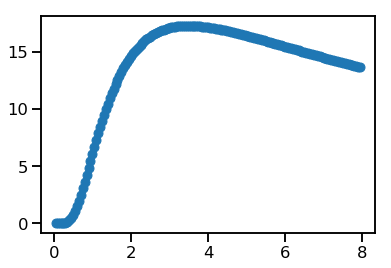

In [22]:
plt.plot(MTs, N, 'o')
print(MTs[np.argmax(N)])

In [28]:
mTa = 3
STa = np.arange(0.05,2,0.05)
tg = 8

MTs_start = 1
MTs_stop = 8
MTs_step = 0.05

STs_start = 1
STs_stop = 2
STs_step = 1

kwargs_s = {'MTs_start':MTs_start, 'MTs_stop':MTs_stop, 'MTs_step':MTs_step,
            'STs_start':STs_start,'STs_stop':STs_stop,'STs_step':STs_step}

MTs = np.arange(MTs_start,MTs_stop,MTs_step)
STs = np.arange(STs_start,STs_stop,STs_step)


EXP_KEY = np.arange(len(STa)).tolist()
for i in range(len(EXP_KEY)):
    EXP_KEY[i] = '{:3d}'.format(EXP_KEY[i]+100)
# for i in range(len(STa)):
EXP_KEY

['100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138']

In [ ]:
for i in range(len(EXP_KEY)):

    sTa = STa[i] 
    kwargs = {'mTa':mTa, 'sTa':sTa, 'tg':tg}
    
    scale_workers = 50
    if scale_workers > 0:
        cluster.scale(scale_workers)

    futures = []
    for sTs in STs:
        def PAR_run_stoch_one(mTs):
            return run_stochastic_one(mTs, sTs, **kwargs)
        fut = client.map(PAR_run_stoch_one, MTs)
        futures.append(fut)
    all_futures = [fu for sublist in futures for fu in sublist]
    dask.distributed.progress(all_futures)
    res = np.array(client.gather(futures)).T
    exp_key = EXP_KEY[i] # MODIFY SO YOU DON'T OVERWRITE!!!!!
    save_experiment(exp_key, res, kwargs, kwargs_s)